**CSI 4106 Introduction to Artificial Intelligence** <br/>
*Assignment 3: Neural Networks*

# Identification

Name: Oluwatobiloba Ogunbi <br/> 
Student Number: 300202843

Name: Vanisha Bagga <br/>
Student Number: 300191679

## 1. Exploratory Analysis

### Loading the dataset

A custom dataset has been created for this assignment. It has been made available on a public GitHub repository:

- [github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3](https://github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3)

Access and read the dataset directly from this GitHub repository in your Jupyter notebook.

You can use this code cell for you import statements and other initializations.

In [5]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import *

Loading the datasets:

In [6]:
test = "https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_test.csv"
train = "https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_train.csv"
valid = "https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_valid.csv"

test_df = pd.read_csv(test)
train_df = pd.read_csv(train)
valid_df = pd.read_csv(valid)

print(test_df.head())
print(train_df.head())
print(valid_df.head())

   2       0  0.1     0.2     0.3     0.4     0.6     0.7     0.8  0.9  ...  \
0  1  0.1111  0.0  0.0000  0.0000  0.2222  0.1111  0.0000  0.0000  0.0  ...   
1  1  0.3750  0.0  0.0625  0.0000  0.0312  0.0312  0.0625  0.0312  0.0  ...   
2  1  0.4516  0.0  0.0000  0.0000  0.0000  0.2742  0.0000  0.0806  0.0  ...   
3  0  0.0000  0.0  0.0625  0.0312  0.0000  0.7500  0.0000  0.0000  0.0  ...   
4  2  0.0000  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  ...   

    0.409   0.410   0.411  0.375.3   0.412   0.413  0.414  0.415   0.416  \
0  0.0000  0.0000  0.0000   0.0000  0.0000  1.0000    0.0    0.0  0.0000   
1  0.0312  0.0312  0.0312   0.0312  0.0000  0.0625    0.0    0.0  0.0000   
2  0.0000  0.0000  0.0000   0.0000  0.0000  0.0000    0.0    0.0  0.0161   
3  0.0938  0.0000  0.1562   0.1250  0.0000  0.0312    0.0    0.0  0.0000   
4  0.1333  0.1333  0.1333   0.0000  0.0667  0.0667    0.0    0.0  0.0000   

   0.417  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  

[

### Data Pre-Processing

2. **Shuffling the Rows**:

    - Since examples are generated by sliding a window across each protein sequence, most adjacent examples originate from the same protein and share 20 positions. To mitigate the potential negative impact on model training, the initial step involves shuffling the **rows** of the data matrix.

In [7]:
from sklearn.utils import shuffle

# Shuffling rows
test_df = shuffle(test_df)
train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

3. **Scaling of Numerical Features**:

    - Since all 462 features are proportions represented as values between 0 and 1, scaling may not be necessary. In our evaluations, using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) actually degraded model performance. Within your pipeline, compare the effects of not scaling the data versus applying [MinMaxScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html). In the interest of time, a single experiment will suffice. It is important to note that when scaling is applied, a uniform method should be used across all columns, given their homogeneous nature.

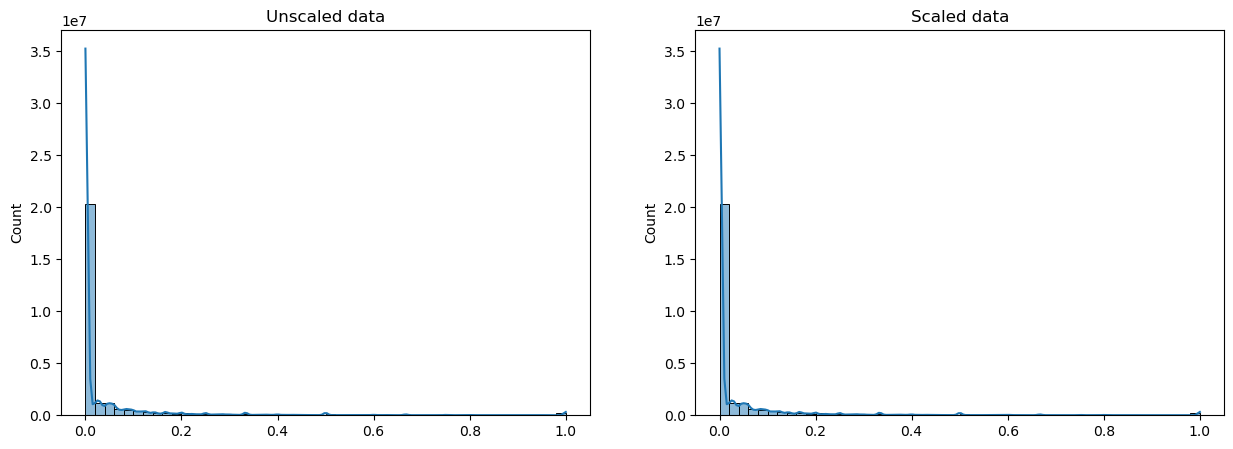

In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# scaling the train data
train_scaled = train_df.copy()

train_scaled.iloc[:, 1:] = scaler.fit_transform(train_scaled.iloc[:, 1:])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
unscaled = train_df.iloc[:, 1:].values.flatten()
scaled = train_scaled.iloc[:, 1:].values.flatten()
sns.histplot(unscaled, ax=ax[0], bins=50, kde=True)
ax[0].set_title('Unscaled')
sns.histplot(scaled, ax=ax[1], bins=50, kde=True)
ax[1].set_title('Scaled')

plt.show()



4. **Isolating the Target and the Data**:

    - In the CSV files, the target and data are combined. To prepare for our machine learning experiments, separate the training data $X$ and the target vector $y$ for each of the three datasets.

In [9]:
X_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values
X_validation = valid_df.iloc[:, 1:].values
y_validation = valid_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values

### Model Development & Evaluation

5. **Model Development**:

    - **Dummy Model**: Implement a model utilizing the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). This model disregards the input data and predicts the majority class. Such model is sometimes called a straw man model.

    - **Basline Model**: As a baseline model, select one of the previously studied machine learning algorithms: Decision Trees, K-Nearest Neighbors (KNN), or Logistic Regression. Use the default parameters provided by scikit-learn to train each model as a baseline. Why did you choose this particular classifier? Why do you think it should be appropriate for this specific task?

    - **Neural Network Model**: Utilizing [Keras](https://keras.io) and [TensorFlow](https://www.tensorflow.org), construct a sequential model comprising an input layer, a hidden layer, and an output layer. The input layer should consist of 462 nodes, reflecting the 462 attributes of each example. The hidden layer should include 8 nodes and employ the default activation function. The output layer should contain three nodes, corresponding to the three classes: helix (0), sheet (1), and coil (2). Apply the softmax activation function to the output layer to ensure that the outputs are treated as probabilities, with their sum equaling 1 for each training example.

    We therefore have three models: dummy, baseline, and neural network.

In [10]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import keras
from keras import Sequential
from keras import layers

# dummy model 
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_validation)

# baseline (logistic reg)
base = LogisticRegression(max_iter=1000)
base.fit(X_train, y_train)
base_pred = base.predict(X_validation)

# neural network
neural = Sequential()
neural.add(layers.Dense(462, input_dim=462, activation='relu'))
neural.add(layers.Dense(8, activation='relu'))
neural.add(layers.Dense(3, activation='softmax'))

neural.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
neural.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_validation, y_validation))

neural_pred = neural.predict(X_validation)

neural.summary()



Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6426 - loss: 0.8138 - val_accuracy: 0.6812 - val_loss: 0.7392
Epoch 2/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7310 - loss: 0.6530 - val_accuracy: 0.7023 - val_loss: 0.6955
Epoch 3/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7782 - loss: 0.5468 - val_accuracy: 0.7002 - val_loss: 0.7248
Epoch 4/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8341 - loss: 0.4271 - val_accuracy: 0.6918 - val_loss: 0.7818
Epoch 5/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8910 - loss: 0.2999 - val_accuracy: 0.6870 - val_loss: 0.8824
Epoch 6/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9312 - loss: 0.1991 - val_accuracy: 0.6779 - val_loss: 1.0595
Epoch 7/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9550 - loss: 0.1377 - val_accuracy: 0.6682 - val_loss: 1.2825
Epoch 8/10
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9684 - loss: 0.1000 - val_accurac

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 462)            │       213,906 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         3,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 652,913 (2.49 MB)

 Trainable params: 217,637 (850.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 435,276 (1.66 MB)

6. **Model Evaluation**:

    - Employ cross-validation to assess the performance of the baseline model. Select a small number of folds to prevent excessive computational demands.

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# cross-validation of baseline
# f1 = cross_val_score(base, X_train, y_train, cv=5, scoring='f1_micro')
# accuracy = cross_val_score(base, X_train, y_train, cv=5, scoring='accuracy')
# prec = cross_val_score(base, X_train, y_train, cv=5, scoring='precision_micro')
# rec = cross_val_score(base, X_train, y_train, cv=5, scoring='recall_micro')

# print("Precision:", precision_score(y_validation, base_pred, average='weighted'))
# print("Recall:", recall_score(y_validation, base_pred, average='weighted'))
# print("F1 Score:", f1_score(y_validation, base_pred, average='weighted'))

# print("Baseline Model Cross-Validation:")
# print("F1 Score: ", f1)
# print("Accuracy: ", accuracy)
# print("Precision: ", prec)
# print("Recall: ", rec)

#classification report of baseline model (lin regression)
labels = ['H', 'E', 'C']

print(classification_report(y_validation, base_pred))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69      2490
           1       0.66      0.46      0.54      1808
           2       0.67      0.76      0.72      3110

    accuracy                           0.67      7408
   macro avg       0.67      0.64      0.65      7408
weighted avg       0.67      0.67      0.67      7408



    - **Training neural networks can be time-consuming.** Consequently, their performance is typically assessed once using a validation set. Make sure to not use the test set until the very end of the assignment.

In [12]:
# Code cell

    - Assess the models using metrics such as precision, recall, and F1-score.

### Hyperparameter Optimization

7. **Baseline Model:**

    - To ensure a fair comparison for our baseline model, we will examine how varying hyperparameter values affect its performance. This prevents the erroneous conclusion that neural networks inherently perform better, when in fact, appropriate hyperparameter tuning could enhance the baseline model's performance.

    - Focus on the following relevant hyperparameters for each model:

        - [DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html): `criterion` and `max_depth`.
  
        - [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html): `penalty`, `max_iter`, and `tol`.
  
        - [KNeighborsClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): `n_neighbors` and `weights`.

    - Employ a grid search strategy or utilize scikit-learn's built-in methods [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html) to thoroughly evaluate all combinations of hyperparameter values. Cross-validation should be used to assess each combination.

    - Quantify the performance of each hyperparameter configuration using precision, recall, and F1-score as metrics.

    - Analyze the findings and offer insights into which hyperparameter configurations achieved optimal performance for each model.

In [47]:
from sklearn.model_selection import GridSearchCV

# parameter grids - we used a grid search strategy 
lrp = {
    'penalty': ['l2'],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2]
}

# scoring metrics
scoring = {
    'f1': make_scorer(f1_score, average= 'weighted'),
    'precision': make_scorer(precision_score, average= 'weighted'),
    'recall': make_scorer(recall_score, average= 'weighted')
}

lr_grid = GridSearchCV(base, lrp, cv=5, scoring=scoring, refit='f1')
lr_grid.fit(X_train, y_train)

results = {}

# extracting grid results
lr_results = pd.DataFrame(lr_grid.cv_results_)

# using max_iter and tol for comparison when plotting
hyperparams = lr_results[['param_max_iter', 'param_tol']]

# best parameters
best = lr_grid.best_params_
print("Best Parameters: ", best)
print("Best f1 score: ", lr_grid.best_score_)  

# plotting the comparisons with barplot
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 3, 1)
# sns.barplot(x='param_max_iter', y='mean_test_f1', data=lr_results)
# plt.title('F1 Score vs Max Iterations')
# plt.subplot(1, 3, 2)
# sns.barplot(x='param_tol', y='mean_test_f1', data=lr_results)
# plt.title('F1 Score vs Tolerance')
# plt.show()





Best Parameters:  {'max_iter': 100, 'penalty': 'l2', 'tol': 0.001}
Best f1 score:  0.6834071655258539


8. **Neural Network:**

    In our exploration and tuning of neural networks, we focus on the following hyperparameters:

    - **Single hidden layer, varying the number of nodes**. 

        - Start with a single node in the hidden layer. Use a graph to depict the progression of loss and accuracy for both the training and validation sets, with the horizontal axis representing the number of training epochs and the vertical axis showing loss and accuracy. Training this network should be relatively fast, so let's conduct training for 50 epochs. Observing the graph, what do you conclude? Is the network underfitting or overfitting? Why?

        - Repeat the above process using 2 and 4 nodes in the hidden layer. Use the same type of graph to document your observations regarding loss and accuracy.

        - Start with 8 nodes in the hidden layer and progressively double the number of nodes until it surpasses the number of nodes in the input layer. This results in seven experiments and corresponding graphs for the following configurations: 8, 16, 32, 64, 128, 256, and 512 nodes. Document your observations throughout the process.
        
        - Ensure that the **number of training epochs** is adequate for **observing an increase in validation loss**. **Tip**: During model development, start with a small number of epochs, such as 5 or 10. Once the model appears to perform well, test with larger values, like 40 or 80 epochs, which proved reasonable in our tests. Based on your observations, consider conducting further experiments, if needed. How many epochs were ultimately necessary?

In [65]:
from keras import Sequential
from keras import layers
import matplotlib.pyplot as plt

# Function to plot loss and accuracy
def plot_loss_accuracy(history, title):
    epochs = range(len(history.history['loss']))
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training')
    plt.plot(epochs, history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()
    
    plt.show()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


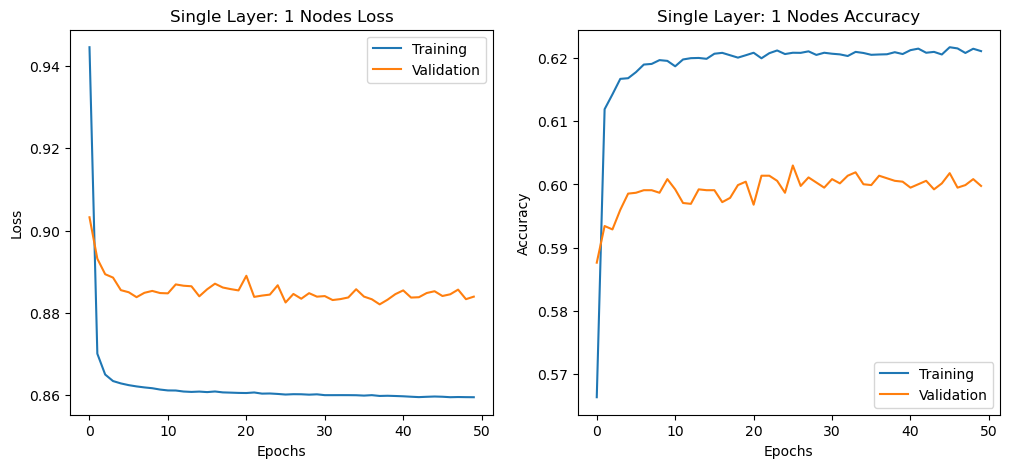

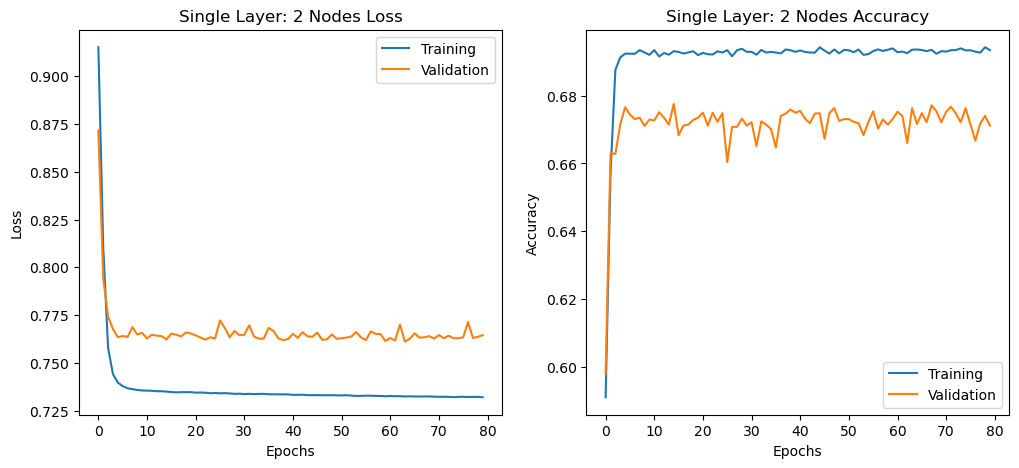

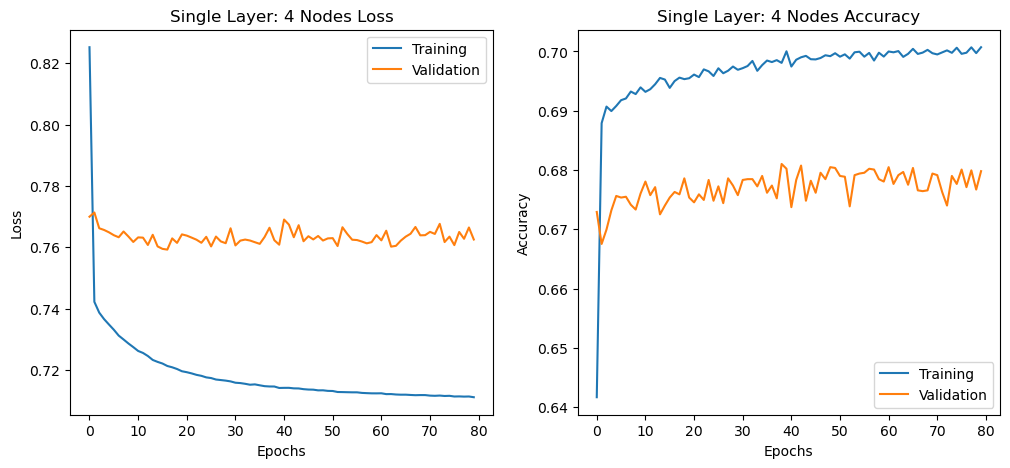

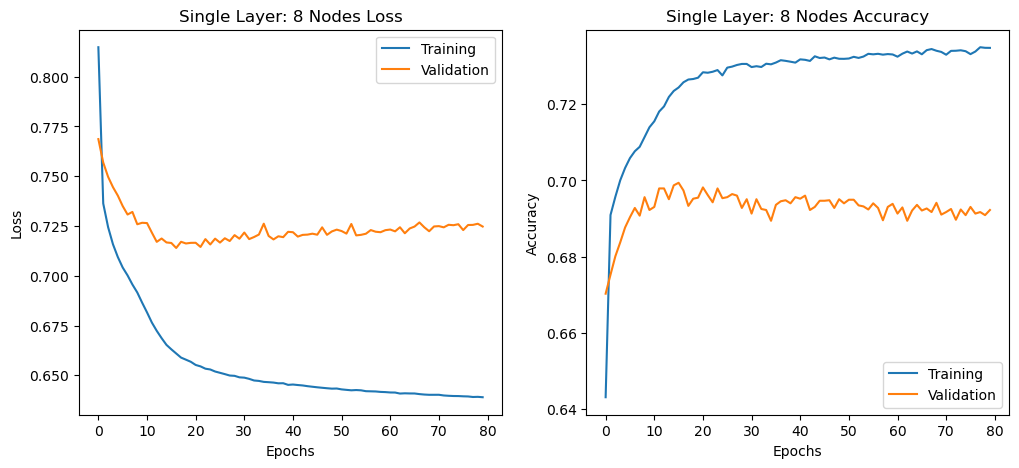

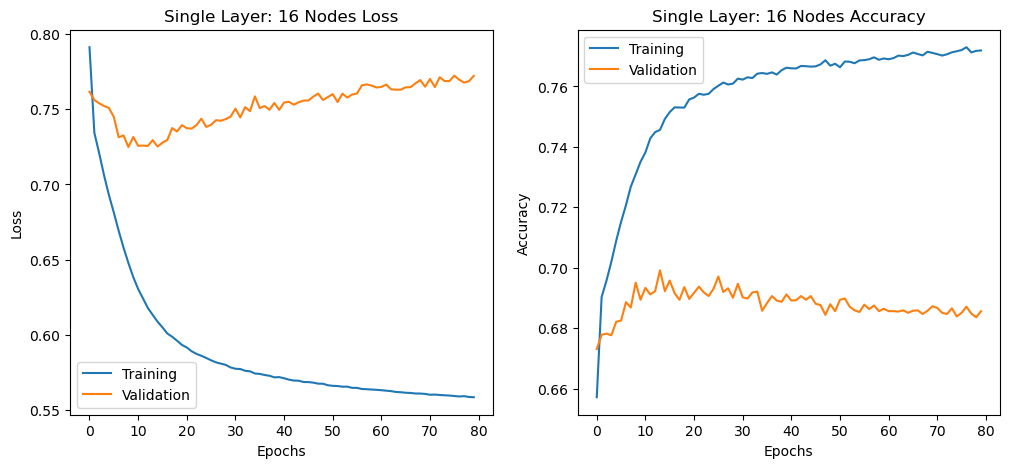

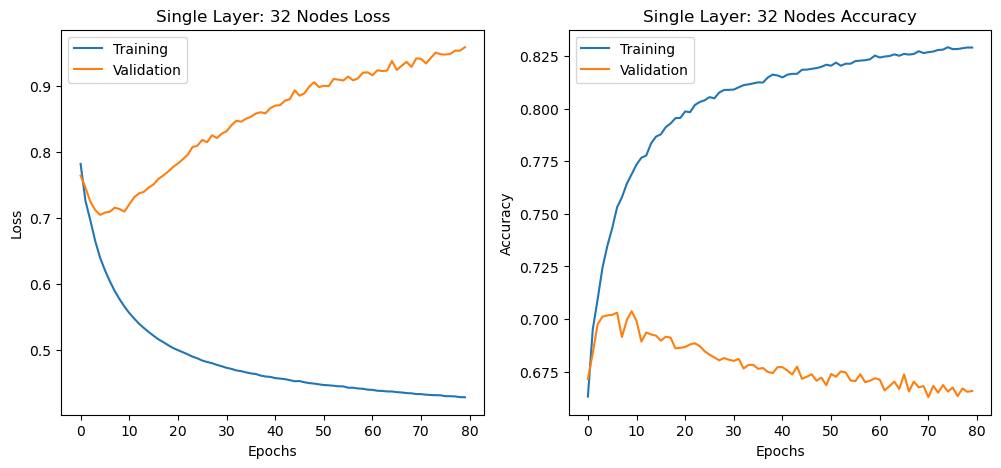

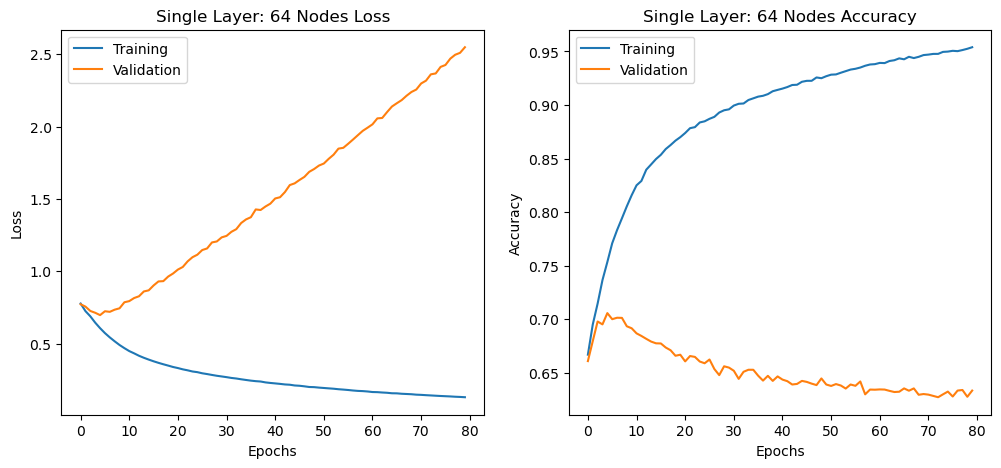

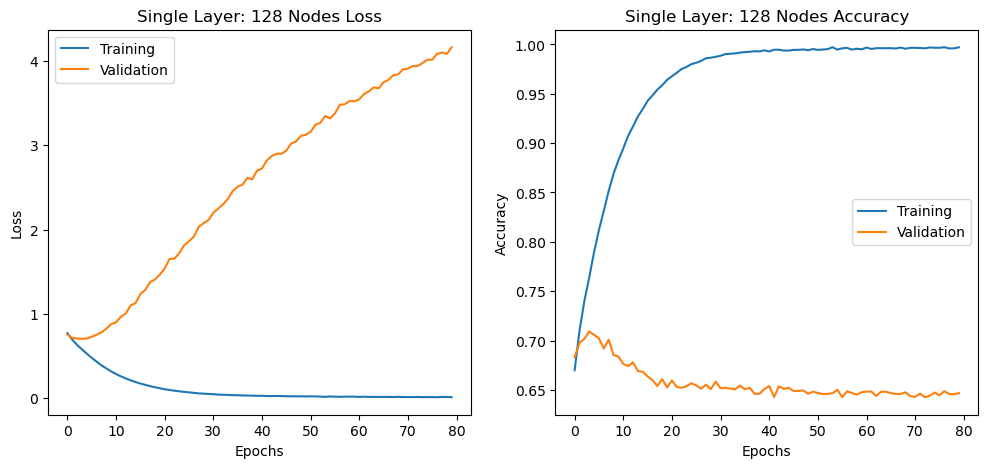

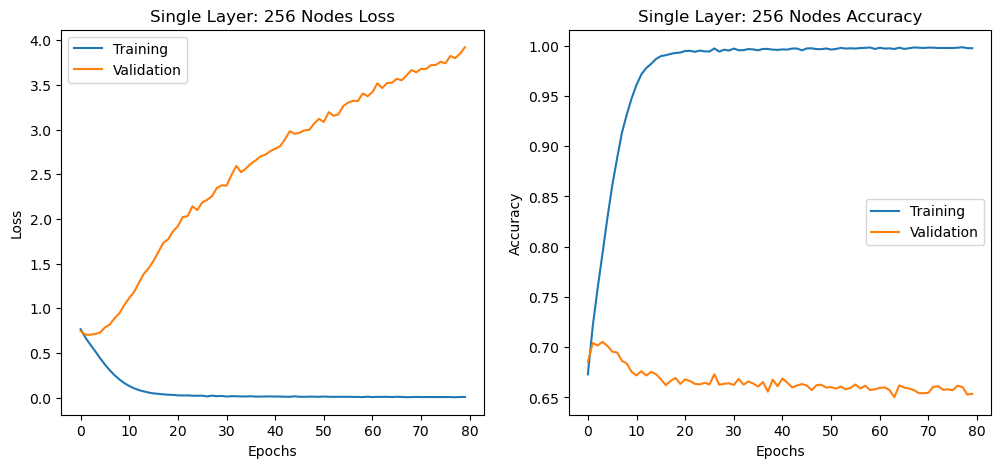

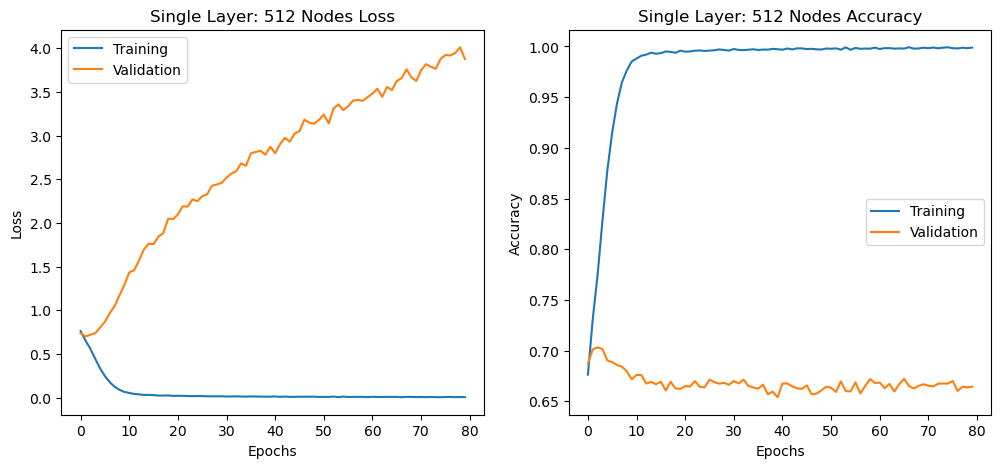

In [66]:
# Different # of nodes in single layer
number_of_nodes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
for n in number_of_nodes:
    neural = Sequential([
        layers.Dense(n, input_dim=462, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    
    if n == 1:
        e = 50
    else:
        e = 80
    neural.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = neural.fit(X_train, y_train, epochs=e, validation_data=(X_validation, y_validation), batch_size=32, verbose=0)
    
    plot_loss_accuracy(history, f'Single Layer: {n} Nodes')

    - **Varying the number of layers**.

        - Conduct similar experiments as described above, but this time vary the number of layers from 1 to 4. Document your findings.

        - How many nodes should each layer contain? Test at least two scenarios. Traditionally, a common strategy involved decreasing the number of nodes from the input layer to the output layer, often by halving, to create a pyramid-like structure. However, recent experience suggests that maintaining a constant number of nodes across all layers can perform equally well. Describe your observations. It is acceptable if both strategies yield similar performance results.

        - Select one your models that exemplifies overfitting. In our experiments, we easily constructed a model achieving nearly 100% accuracy on the training data, yet showing no similar improvement on the validation set. Present this neural network along with its accuracy and loss graphs. Explain the reasoning for concluding that the model is overfitting.

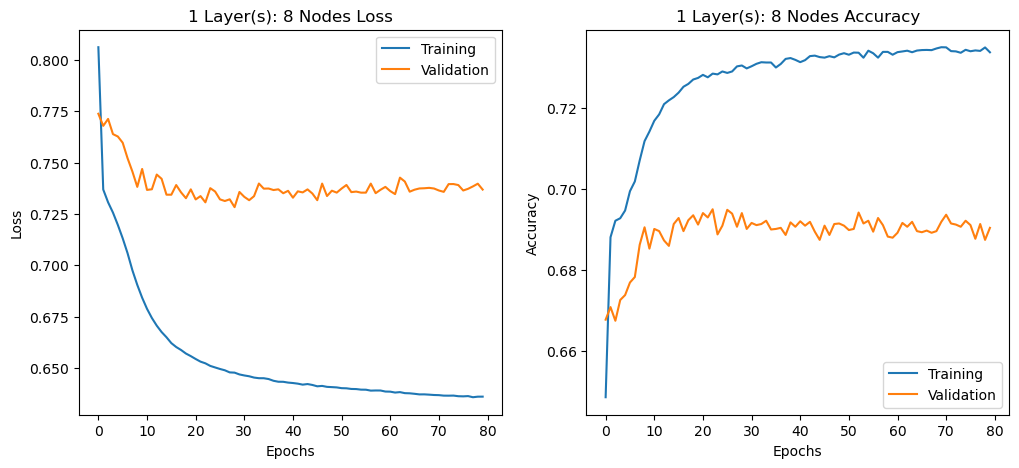

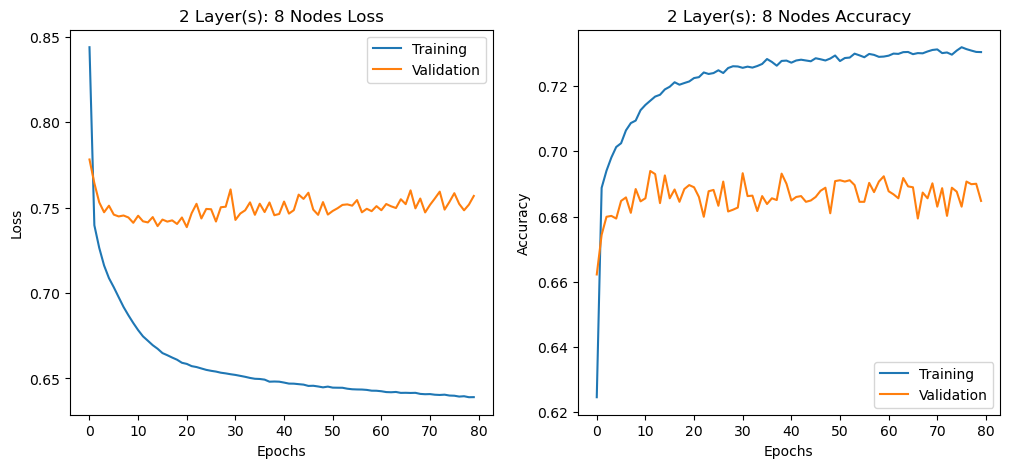

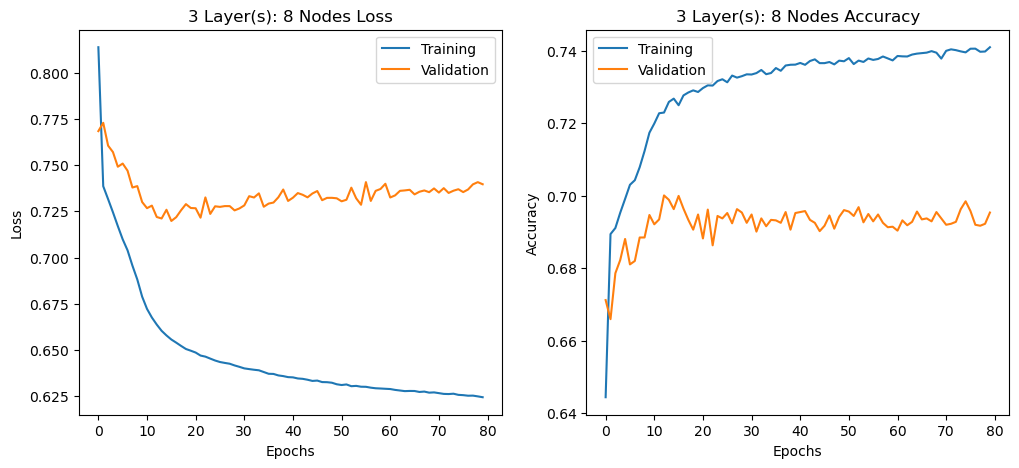

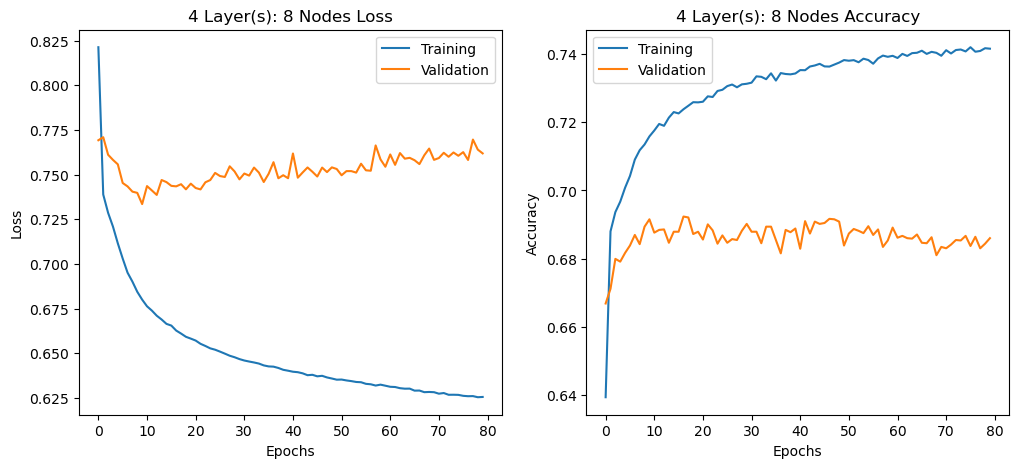

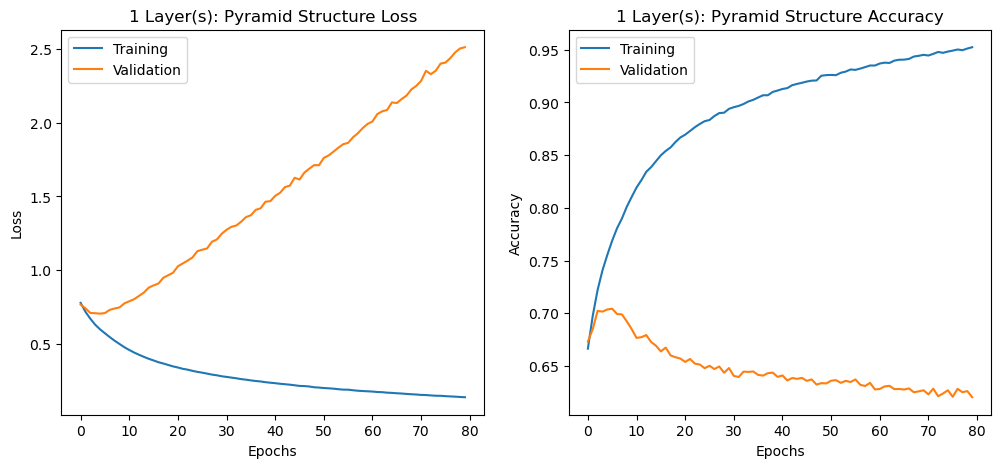

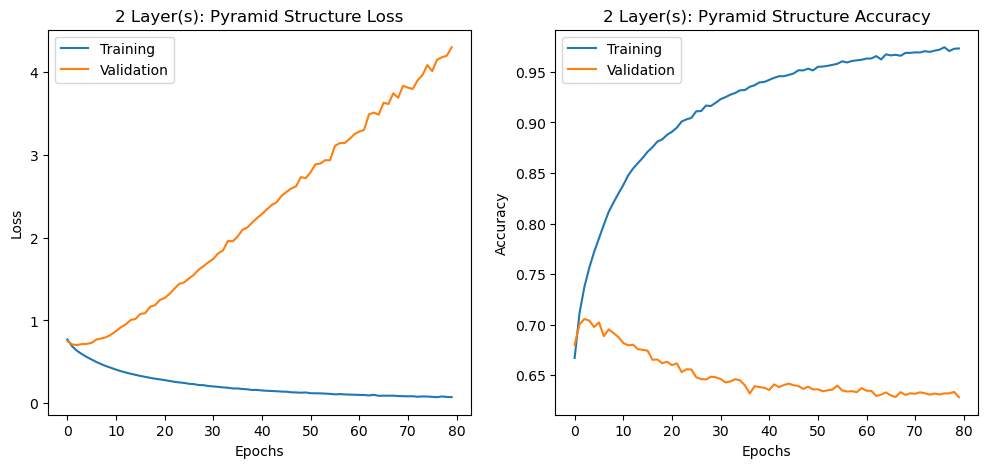

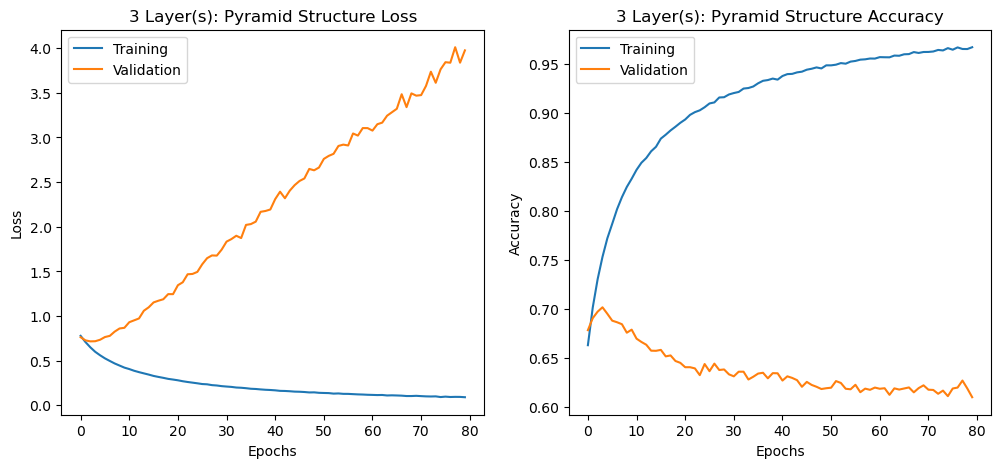

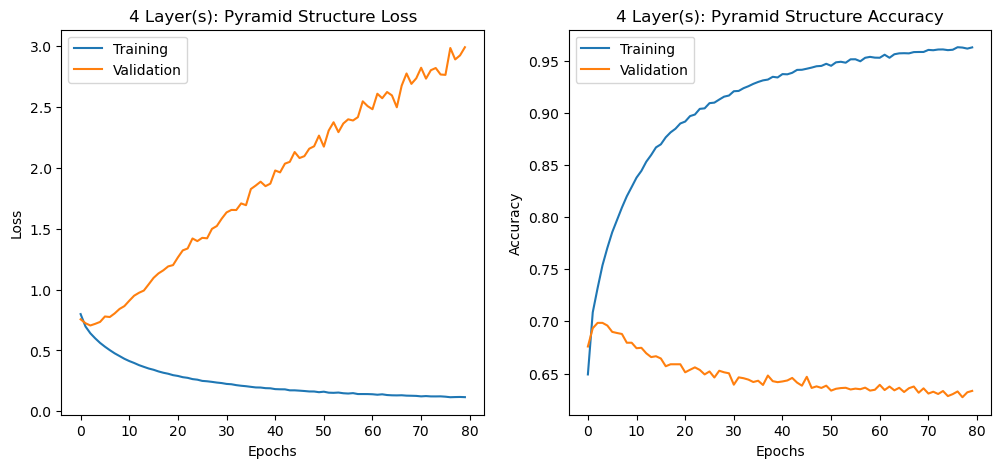

In [67]:
node_test = {
    "8 Nodes": [8, 8, 8, 8],  # Same node
    "Pyramid Structure": [64, 32, 16, 8] # Pyramid structure
}

for key, value in node_test.items():
    for num_layer in range(1, 5):  # 1 to 4 layers
        neural = Sequential()

        for i in range(num_layer):
            if i == 0:
                neural.add(layers.Dense(value[i], activation='relu', input_dim=462))
            else:
                neural.add(layers.Dense(value[i], activation='relu'))
        neural.add(layers.Dense(3, activation='softmax'))

        neural.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = neural.fit(X_train, y_train, epochs=80, validation_data=(X_validation, y_validation), batch_size=32, verbose=0)
        
        plot_loss_accuracy(history, f'{num_layer} Layer(s): {key}')

*Gonna choose overfitting model and add explanation after I finish code for my parts - Vani*

so far, 4 layers and 8 nodes with 80 epoch gives best

    - **Activation function**.

        - Present results for one of the configurations mentioned above by varying the activation function. Test at least `relu` (the default) and `sigmoid`. The choice of the specific model, including the number of layers and nodes, is at your discretion. Document your observations accordingly.

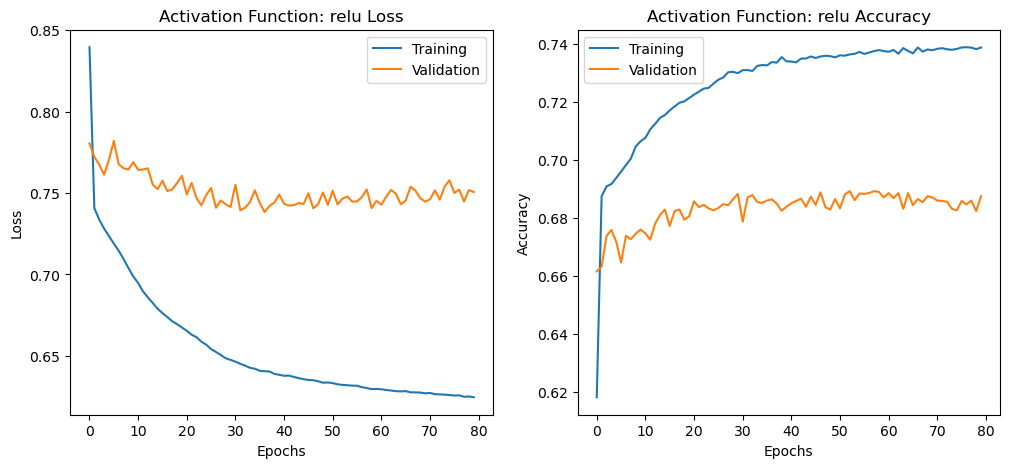

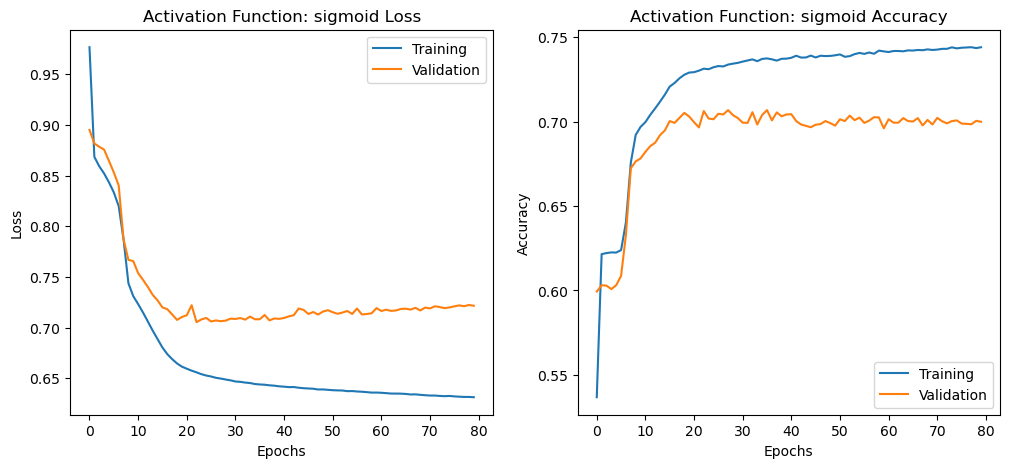

In [68]:
activations = ['relu', 'sigmoid']
for a in activations:
    neural = Sequential([
        layers.Dense(8, input_dim=462, activation=a),
        layers.Dense(8, activation=a),
        layers.Dense(8, activation=a),
        layers.Dense(8, activation=a),
        layers.Dense(3, activation='softmax')
    ])
    
    neural.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = neural.fit(X_train, y_train, epochs=80, validation_data=(X_validation, y_validation), batch_size=32, verbose=0)
    
    plot_loss_accuracy(history, f'Activation Function: {a}')

    - **Regularization** in neural networks is a technique used to prevent overfitting.

        - One technique involves adding a penalty to the loss function to discourage excessively complex models. Apply an `l2` penalty to some or all layers. Exercise caution, as overly aggressive penalties have been problematic in our experiments. Begin with the default `l2` value of 0.01, then reduce it to 0.001 and 1e-4. Select a specific model from the above experiments and present a case where you successfully reduced overfitting. Include a pair of graphs comparing results with and without regularization. Explain your rationale to conclude that overfitting has been reduced. Do not expect to completely eliminate overfitting. Again, this is a challenging dataset to work with.

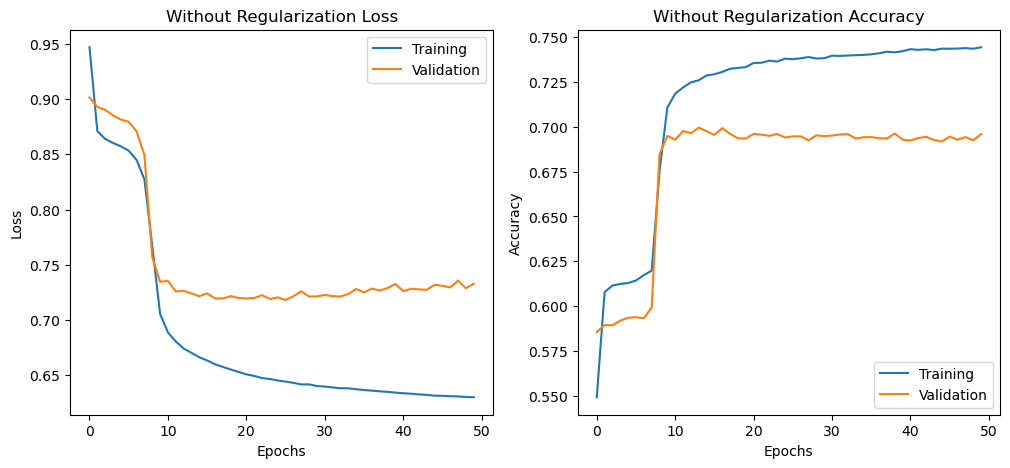

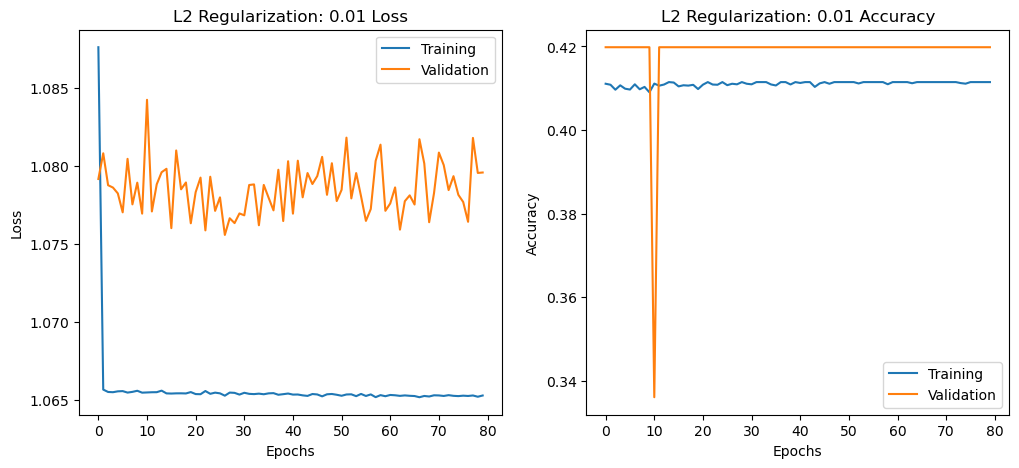

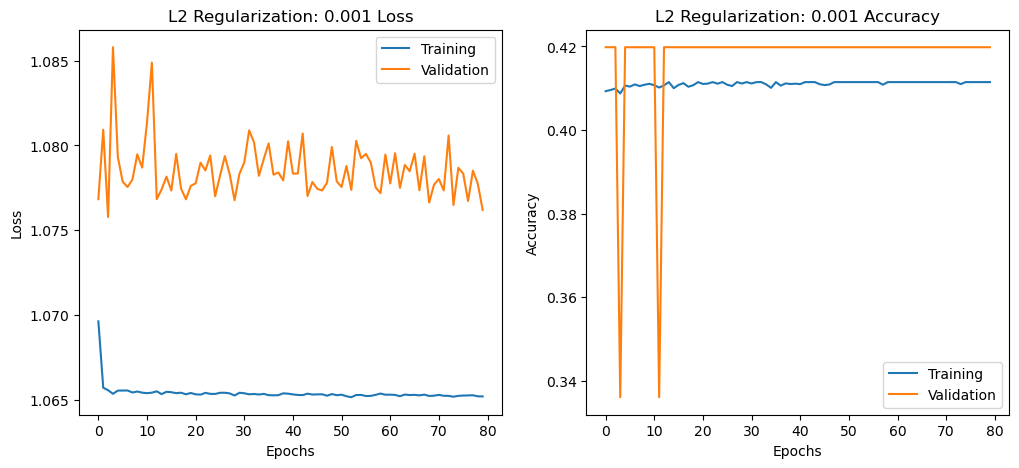

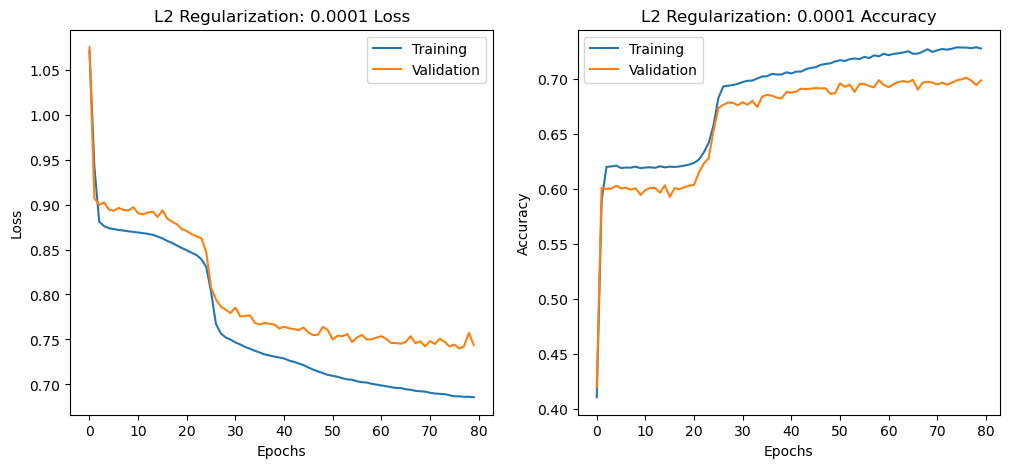

In [69]:
from keras import layers, regularizers

# Training without regularization 
neural_no_reg = Sequential([
        layers.Dense(8, input_dim=462, activation='relu'),
        layers.Dense(8, activation='sigmoid'),
        layers.Dense(8, activation='sigmoid'),
        layers.Dense(8, activation='sigmoid'),
        layers.Dense(3, activation='softmax')
])
neural_no_reg.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_no_reg = neural_no_reg.fit(X_train, y_train, epochs=50, validation_data=(X_validation, y_validation), batch_size=32, verbose=0)
plot_loss_accuracy(history_no_reg, 'Without Regularization')

values = [0.01, 0.001, 1e-4]
for l2 in values:
    neural = Sequential([
        layers.Dense(8, input_dim=462, activation='sigmoid', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(8, activation='sigmoid', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(8, activation='sigmoid', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(8, activation='sigmoid'),
        layers.Dense(3, activation='softmax')
    ])
    
    neural.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = neural.fit(X_train, y_train, epochs=80, validation_data=(X_validation, y_validation), batch_size=32, verbose=0)
    
    plot_loss_accuracy(history, f"L2 Regularization: {l2}")

        - Dropout layers are a regularization technique in neural networks where a random subset of neurons is temporarily removed during training. This helps prevent overfitting by promoting redundancy and improving the network's ability to generalize to new data. Select a specific model from the above experiments where you have muliple layers and experiment adding one or of few dropout layers into your network. Experiment with two different rates, say 0.25 and 0.5. Document your observations.

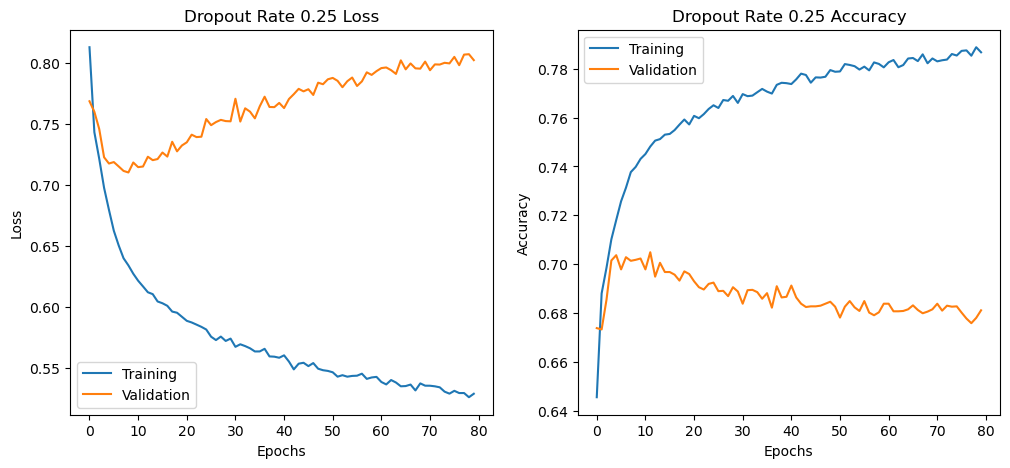

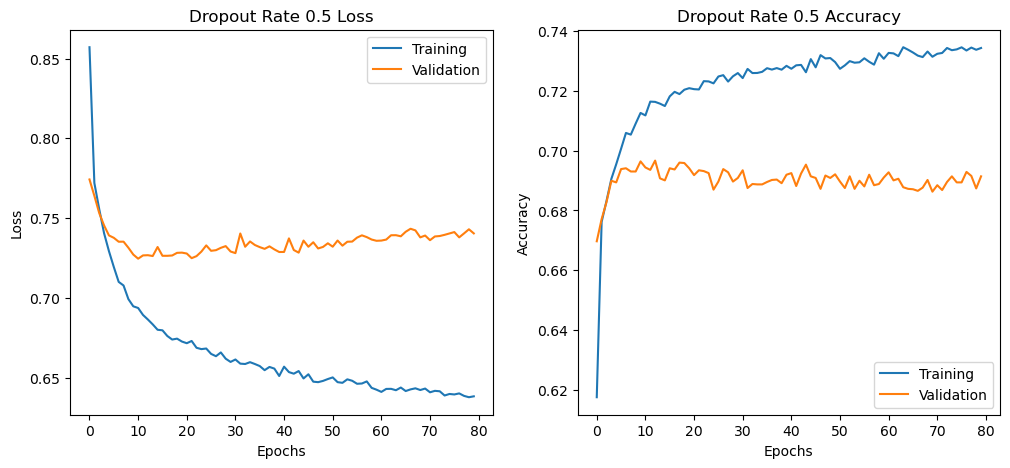

In [70]:
dropout_rates = [0.25, 0.5]
for d in dropout_rates:
    neural = Sequential([
        layers.Dense(32, input_dim=462, activation='relu'),
        layers.Dropout(d),
        layers.Dense(32, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    
    neural.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = neural.fit(X_train, y_train, epochs=80, validation_data=(X_validation, y_validation), batch_size=32, verbose=0)
    
    plot_loss_accuracy(history, f'Dropout Rate {d}')

        - Summarize your experiments with using a graphical representation such as Figure 6.15 [on this page](https://egallic.fr/Enseignement/ML/ECB/book/deep-learning.html).

In [76]:
def plot_experiment_accuracy_histories(histories, labels):
    plt.figure(figsize=(10, 6))
    
    for history, label in zip(histories, labels):
        epochs = range(len(history.history['accuracy']))
        plt.plot(epochs, history.history['val_accuracy'], linestyle='--', label=f'{label} (Validation)')
        plt.plot(epochs, history.history['accuracy'], linestyle='-', label=f'{label} (Training)')
    
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Summarizing Accuracy Results')
    plt.legend()
    plt.show()

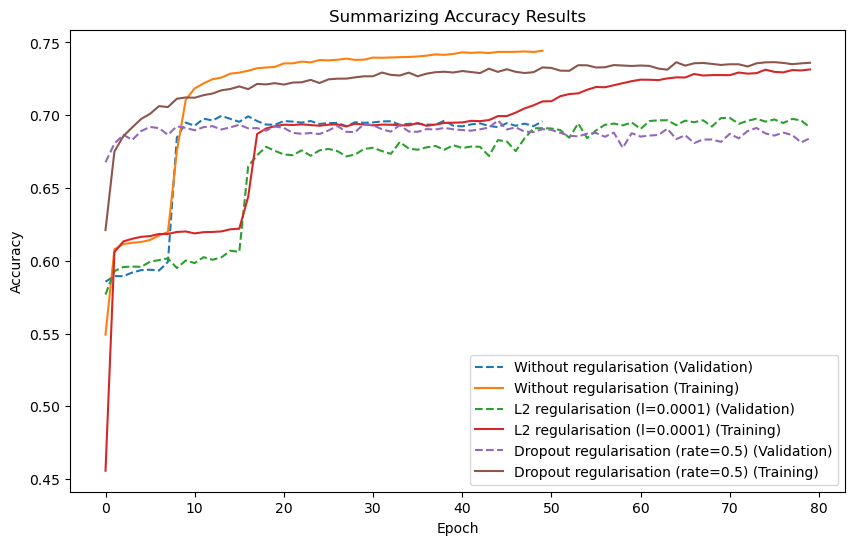

In [77]:
neural_l2 = Sequential([
    layers.Dense(8, input_dim=462, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dense(8, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dense(8, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dense(8, activation='sigmoid'),
    layers.Dense(3, activation='softmax')
])
neural_l2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_l2 = neural_l2.fit(X_train, y_train, epochs=80, validation_data=(X_validation, y_validation), batch_size=32, verbose=0)

neural_dropout = Sequential([
        layers.Dense(32, input_dim=462, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    
neural_dropout.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_dropout = neural_dropout.fit(X_train, y_train, epochs=80, validation_data=(X_validation, y_validation), batch_size=32, verbose=0)

   
plot_experiment_accuracy_histories(
    histories=[history_no_reg, history_l2, history_dropout],
    labels=['Without regularisation', 'L2 regularisation (l=0.0001)', 'Dropout regularisation (rate=0.5)']
)

        - Early stopping is a regularization technique in neural network training wherein the process is halted when validation set performance starts to decline, thus preventing overfitting by avoiding the learning of noise in the training data. From all the experiments conducted thus far, choose **one** configuration (the number of layers, number of nodes, activation function, L2 penalty, and dropout layers) that yielded the best performance. Use a graph of loss and accuracy to determine the optimal number of training iterations for this network. What is the optimal number of epochs for this network configuration and why?

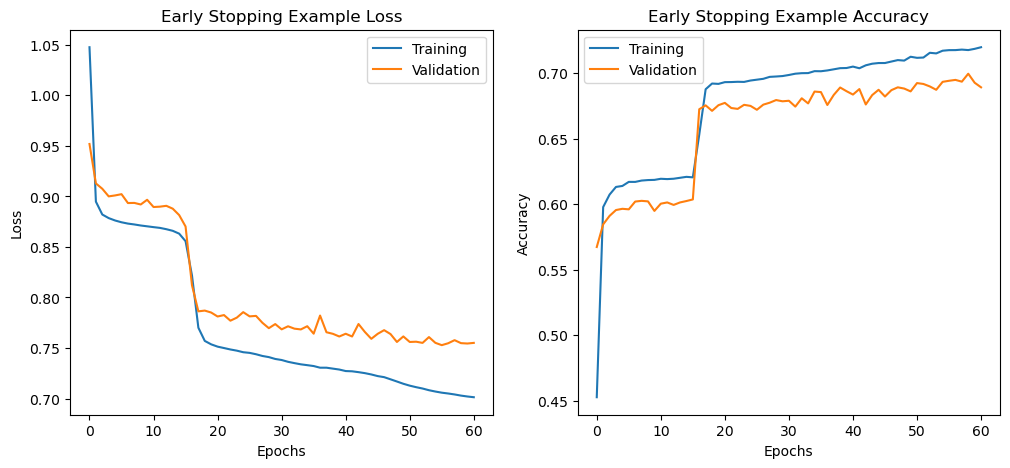

In [71]:
from keras import callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

l2 = 1e-4
neural = Sequential([
    layers.Dense(8, input_dim=462, activation='sigmoid', kernel_regularizer=regularizers.l2(l2)),
    layers.Dense(8, activation='sigmoid', kernel_regularizer=regularizers.l2(l2)),
    layers.Dense(8, activation='sigmoid', kernel_regularizer=regularizers.l2(l2)),
    layers.Dense(8, activation='sigmoid'),
    layers.Dense(3, activation='softmax')
])

neural.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = neural.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation), batch_size=32, verbose=0, callbacks=[early_stopping])

plot_loss_accuracy(history, 'Early Stopping Example')

### Test

9. **Model Comparison**:

    - Evaluate the baseline model on the test set, using the optimal parameter set identified through grid search. Additionally, apply your best-performing neural network configuration to the test set.

    - Quantify the performance of the baseline model (best hyperparameter configuration) and your neural network (best configuration) using precision, recall, and F1-score as metrics. How do these two models compare to the dummy model?

    - Provide recommendations on which model(s) to choose for this task and justify your choices based on the analysis results.

In [50]:
import numpy as np

nn = neural.predict(X_test)
nn_argmax = np.argmax(nn, axis=1)

prec = precision_score(y_test, nn_argmax, average='weighted')
rec = recall_score(y_test, nn_argmax, average='weighted')
f1 = f1_score(y_test, nn_argmax, average='weighted')

print("Metrics for Neural Network:")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\n")

basep = base.predict(X_test)
precp = precision_score(y_test, basep, average='weighted')
recp = recall_score(y_test, basep, average='weighted')
f1p = f1_score(y_test, basep, average='weighted')

print("Metrics for Baseline Model:")
print(f"Precision: {precp:.4f}")
print(f"Recall: {recp:.4f}")
print(f"F1-Score: {f1p:.4f}")


233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
Metrics for Neural Network:
Precision: 0.6929
Recall: 0.6924
F1-Score: 0.6916


Metrics for Baseline Model:
Precision: 0.7147
Recall: 0.7152
F1-Score: 0.7122


# Resources

> https://keras.io/guides/sequential_model/